<h1>Transit Data Application</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [1]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 315,
                "current_status": "IN_TRANSIT_TO",
                "current_stop_sequence": 1,
                "direction_id": 0,
                "label": "1911",
                "latitude": 42.37304,
                "longitude": -71.11728,
                "occupancy_status": "MANY_SEATS_AVAILABLE",
                "speed": null,
                "updated_at": "2022-08-08T15:50:23-04:00"
            },
            "id": "y1911",
            "links": {
                "self": "/vehicles/y1911"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": {
                        "id": "110",
                        "type": "stop"
                    }
                },
                "trip": {

Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [1]:
import os
import pymysql
import pandas as pd

host = '127.0.0.1'
port = '3306'
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

df.tail(10)

/Users/mel/Library/Python/3.8/lib/python/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,record_num,route_number,id,bearing,current_status,current_stop_sequence,direction_id,label,latitude,longitude,occupancy_status,speed,updated_at
13691,13692,1,y1740,306,IN_TRANSIT_TO,15.0,0,1740,42.359524,-71.094133,MANY_SEATS_AVAILABLE,None,2022-08-09 09:36:12
13692,13693,1,y1902,0,IN_TRANSIT_TO,8.0,0,1902,42.336812,-71.077071,MANY_SEATS_AVAILABLE,None,2022-08-09 10:06:29
13693,13694,1,y1892,307,IN_TRANSIT_TO,18.0,0,1892,42.365207,-71.103496,MANY_SEATS_AVAILABLE,None,2022-08-09 10:06:44
13694,13695,1,y1877,135,IN_TRANSIT_TO,9.0,1,1877,42.360480,-71.095510,MANY_SEATS_AVAILABLE,None,2022-08-09 10:06:48
13695,13696,1,y1857,0,IN_TRANSIT_TO,1.0,0,1857,42.339086,-71.057599,None,None,2022-08-09 10:06:44
13696,13697,1,y1830,135,IN_TRANSIT_TO,1.0,0,1830,42.329830,-71.083950,None,None,2022-08-09 10:06:35
13697,13698,1,y1792,0,IN_TRANSIT_TO,1.0,1,1792,42.329718,-71.083495,MANY_SEATS_AVAILABLE,None,2022-08-09 10:06:41
13698,13699,1,y1772,0,IN_TRANSIT_TO,14.0,0,1772,42.350149,-71.089064,MANY_SEATS_AVAILABLE,None,2022-08-09 10:06:17
13699,13700,1,y1740,0,IN_TRANSIT_TO,15.0,1,1740,42.341479,-71.083170,MANY_SEATS_AVAILABLE,None,2022-08-09 10:06:36
13700,13701,1,y1737,298,IN_TRANSIT_TO,1.0,0,1737,42.331889,-71.078950,None,None,2022-08-09 10:06:46



The code below saves the data as a csv file to the local directory as a backup.

In [2]:

df.to_csv('mbta.csv')

<h1>What is the average time it takes for a bus to complete the route</h1>

<h1>Provide a Visualization based on the data</h1>

Below I create a pie chart of the occupancy status of the busses that are traveling on route 1.  The pie chart show the quantity of times the bus occupancy is either full, few seats are available or many seats are available.

In [96]:
occupancy = df.groupby(["occupancy_status"])["occupancy_status"].count()
occupancy

occupancy_status
FEW_SEATS_AVAILABLE     2236
FULL                     483
MANY_SEATS_AVAILABLE    9195
Name: occupancy_status, dtype: int64

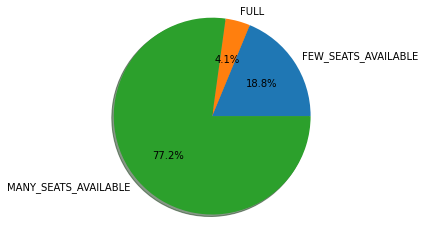

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.pie(occupancy, labels = ["FEW_SEATS_AVAILABLE","FULL", "MANY_SEATS_AVAILABLE"], shadow = True, autopct='%1.1f%%')
ax.axis('equal')

fig.savefig('visualization.jpg')
plt.show()


I am able to determine that 77.2% of the time the buses are running that there are many seats available. Only 4.1% of the time is the bus full and 18.8% of the time there are few seats available. 

<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In order to calculate the speed of the bus, I will use the formula for calculating speed based on distance and time.  

*speed = distance / time*

In order to calculate the distance between two longitudes and latitude coordinates, I will use the haversine function from the haversine library. 

In [6]:
from haversine import haversine, Unit

In [7]:
start_stop_sequence = 1.0
max_stop_sequence = max(df['current_stop_sequence']) # Gets the maxium stop sequence

print(start_stop_sequence)
print(max_stop_sequence)

1.0
24.0


The distance between the start stop and last stop can be calculated by the difference between the 2 coordinates.

First, I begin by querying the dataset for when the current_stop_sequence == 1 and calculate the average latitude and longitudes that the busses stop at.

In [16]:
start_stop_1 = df.query('current_stop_sequence == 1')
start_stop_1_coord = start_stop_1[["latitude", "longitude"]].mean()

start_stop_1_coord

latitude     42.343225
longitude   -71.093657
dtype: float64

I repeat the same process but when the current_stop_sequence == 24 and calculate the average latitude and longitudes that the busses stop at.

In [17]:
start_stop_24 = df.query('current_stop_sequence == 24')
start_stop_24_coord = start_stop_24[["latitude", "longitude"]].mean()

start_stop_24_coord

latitude     42.348684
longitude   -71.098116
dtype: float64

I use the haversine function to calculate the distance between stop sequence 1 and 24.

In [60]:
start_stop_1=(42.343225,  -71.093657)
end_stop_24=(42.348684, -71.098116) 
avg_distance = haversine(start_stop_1, end_stop_24, unit='mi') # in miles

avg_distance 

0.44058477892569514

After analyzing the dataset, I based the assumption that the record numbers happened in order.  I decided to extract 7 time differences between start 1 and stop 24 to compare the average time it takes to complete the bus route.

I extracted the time difference for 7 different busses from stop 24 and stop 1. I selected the busses based on if they completed all 24 routes or not.  The time difference below are in hours


In [61]:
from datetime import datetime

time_format = "%m/%d/%y %H:%M"

In [62]:
# Bus ID = y1723

start1723 = datetime.strptime("8/8/22 22:06", time_format)
stop1723 = datetime.strptime("8/8/22 23:30", time_format)
diff1723 = (stop1723 - start1723).total_seconds() / 3600 

diff1723


1.4

In [63]:
# Bus ID = y1740

start1740 = datetime.strptime("8/9/22 0:16", time_format)
stop1740 = datetime.strptime("8/9/22 1:34", time_format)
diff1740 = (stop1740 - start1740).total_seconds() / 3600 

diff1740

1.3

In [64]:
# Bus ID = y1751

start1751 = datetime.strptime("8/8/22 22:25", time_format)
stop1751 = datetime.strptime("8/8/22 23:46", time_format)
diff1751 = (stop1751 - start1751).total_seconds() / 3600 

diff1751

1.35

In [65]:
# Bus ID = y1780

start1780 = datetime.strptime("8/8/22 23:21", time_format)
stop1780 = datetime.strptime("8/9/22 0:38", time_format)
diff1780 = (stop1780 - start1780).total_seconds() / 3600 

diff1780

1.2833333333333334

In [66]:
# Bus ID = y1852

start1852 = datetime.strptime("8/8/22 22:27", time_format)
stop1852 = datetime.strptime("8/8/22 23:47", time_format)
diff1852 = (stop1852 - start1852).total_seconds() / 3600 

diff1852

1.3333333333333333

In [67]:
# Bus ID = y1883

start1883 = datetime.strptime("8/9/22 0:00", time_format)
stop1883 = datetime.strptime("8/9/22 1:18", time_format)
diff1883 = (stop1883 - start1883).total_seconds() / 3600 

diff1883

1.3

In [68]:
# Bus ID = y1911

start1911 = datetime.strptime("8/8/22 22:53", time_format)
stop1911 = datetime.strptime("8/9/22 0:33", time_format)
diff1911 = (stop1911 - start1911).total_seconds() / 3600 

diff1911

1.6666666666666667

In [69]:
average_time = (diff1723 + diff1740 + diff1751 + diff1780 + diff1852 + diff1883 + diff1911)/7

average_time

1.3761904761904762

It takes on average about 1.37 hours for the bus to complete the route.

In order to calculate the speed in miles per hour. 

In [71]:
speed = avg_distance/average_time

print("Average speed in miles per hour for a bus to complete route 1 is : " + str(speed))

Average speed in miles per hour for a bus to complete route 1 is : 0.3201481092539653
